![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [6]:
# Entrenamiento de arbol con datos
man_tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)

In [7]:
y_pred = tree_predict(X_test, man_tree)

In [8]:
from sklearn.metrics import accuracy_score
man_tre_acc = accuracy_score(y_test, y_pred)
man_tre_acc

0.8412240184757506

Realizando un árbol manual sin limitar la profundidad máxima y una ganancia mínima de 0.001 con 10 particiones por variables, se consigue un accuracy de 0.8412

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(1)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [10]:
# Construcción un árbol de decisión para cada muestra boostrap
from sklearn.tree import DecisionTreeClassifier

# Definición del modelo usando DecisionTreeClassifier de sklearn
treeclas = DecisionTreeClassifier(max_depth=None, random_state=1)

# DataFrame para guardar las predicciones de cada árbol
pred_y = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    train_X = X_train.iloc[sample, 0:]
    train_y = y_train.iloc[sample]
    treeclas.fit(train_X, train_y)
    pred_y.iloc[:,i] = treeclas.predict(X_test)
    
pred_y

,0,1,2,3,4,5,6,7,8,9
320351,1,1,1,1,1,1,1,1,1,1
224969,1,1,1,1,1,0,1,1,1,1
79143,0,0,0,0,0,0,0,0,0,0
209210,1,1,1,1,1,1,1,1,1,1
144843,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
287657,1,1,1,1,1,1,1,1,1,1
213830,0,0,0,0,1,1,0,0,0,0
118888,0,0,0,0,0,0,0,0,0,0
397426,0,0,0,0,0,0,0,0,0,0


In [11]:
# Calcular indices de accuracy por cada arbol entrenado
for i in range(n_B):
    print(i, ' ' ,accuracy_score(y_test, pred_y[i]))

0   0.8204387990762124
1   0.8198614318706697
2   0.8224595842956121
3   0.8210161662817552
4   0.836027713625866
5   0.8340069284064665
6   0.8224595842956121
7   0.8340069284064665
8   0.8279445727482679
9   0.8285219399538106


In [12]:
# Indice de accuracy para el total de arboles usando votación mayoritaria
clas_tree_acc = accuracy_score(y_test, pred_y.mode(axis=1)[0])
clas_tree_acc

0.8400692840646651

Entrenando 10 árboles y con todas las variables con el modelo bagging se encuentra que cada modelo tiene un desempeño inferior al obtenido con el árbol manual, y la diferencia entre cada árbol indica una relación con la muestra usada para realizar el entrenamiento. Sin embargo, el ensamblaje de los 10 árboles presenta una mejora respecto al desempeño de cada árbol, pero que no supera el árbol realizado manualmente sin muestreo bagging.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [13]:
# Celda 3
max_feat = np.log2(X_train.shape[1]).astype(int)

from sklearn.ensemble import BaggingClassifier
bagclas = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_features=3, random_state=1)

In [14]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagclas.fit(X_train, y_train)
y_pred = bagclas.predict(X_test)
bag_tree_acc = accuracy_score(y_test, y_pred)
bag_tree_acc

0.8530600461893765

Realizando el bagging con la librería y limitando la cantidad de variables en cada partición el modelo logra superar tanto el modelo de bagging manual como el árbol manual, mostrando una relación entre el desempeño y la cantidad de variables usadas.

En este caso se tiene un **accuracy de 0.8531 evaluado en el conjunto de test**.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [15]:
# Celda 4

# Librerias para implementar Random Forest de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de clasificación
clf_rf_default = RandomForestClassifier(random_state=1)
clf_rf_default

# Entrenamiento del modelo Random Forest con los parámetros por defecto
clf_rf_default.fit(X_train, y_train)

# Impresión de desempeño del modelo usando la función cross_val_score
#pd.Series(cross_val_score(clf_rf_default, X_train, y_train, cv=10)).describe()

# Predicciones con el Random Forest y los parámetros por defecto
y_pred_rf_default_train = clf_rf_default.predict(X_train) # Predicción en train
y_pred_rf_default_test = clf_rf_default.predict(X_test) # Predicción en test

# Calculo del accuracy para modelo Random Forest con parámetros por defecto
acc_rf_default_train = accuracy_score(y_train, y_pred_rf_default_train) # Accuracy en train
acc_rf_default_test = accuracy_score(y_test, y_pred_rf_default_test) # Accuracy en test
print('Accuracy evaluado respecto a la muestra de train: ', acc_rf_default_train)
print('Accuracy evaluado respecto a la muestra de test: ', acc_rf_default_test)

Accuracy evaluado respecto a la muestra de train:  0.998151045370502
Accuracy evaluado respecto a la muestra de test:  0.8302540415704388


En la celda anterior se ha implementado, entrenado y evaluado un modelo de Random Forest con los parámetros por defecto y usando la semilla *random_state=1* para poder reproducir ciertos resultados. **El modelo Random Forest se ha evaluado calculando el accurray en el conjunto de train y el de test**, y al compararlos **se puede ver un sobre-ajuste (overfitting) en el modelo porque en el conjunto de train hay un valor alto de accuracy (0.998), y un valor menor, con amplia diferencia, para el accuracy en el cojunto de test (0.830)**. Esta clara diferencia entre los dos valores de accuracy permite ver que el modelo se ha entrenado o ajustado muy bien a los datos de entrenamiento, pero al evaluarlo en datos nuevos (y_test) no tiene el poder predictivo y de generalización que se busca en un modelo de este tipo. Un buen indicio de generalización es que los dos valores del accuracy (tanto en train como en test) den lo más alto posible y lo más cercano entre ellos, esto permite tener una mejor garantía para la cualidad de generalización del modelo. Por ello en la siguiente sección se busca calibrar algunos parámetros importantes del modelo Random Forest en busca de una mejora en la generalización.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [16]:
# Celda 5


# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier(random_state=1)
clf

RandomForestClassifier(random_state=1)

##### Calibración del parámetro n_estimators
Se inicia calibrando el parámetro **n_estimators**, es decir, el número de árboles que tendrá el bosque aleatorio.

In [17]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())


In [18]:
from sklearn.model_selection import cross_validate

rf = RandomForestClassifier()
cv_results = cross_validate(rf, X_train, y_train, cv=3, return_estimator=True)

In [19]:
cv_results["estimator"]

[RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()]

In [20]:
y_pre = cv_results['estimator'][1].predict(X_test)
y_pre

array([1, 1, 0, ..., 0, 0, 0])

Text(0, 0.5, 'Accuracy')

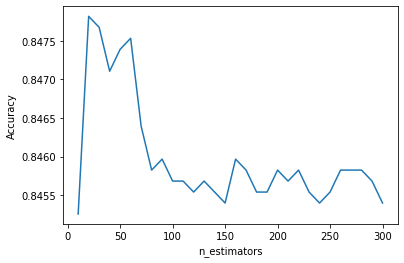

In [21]:
import matplotlib.pyplot as plt

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

El comportamiento del desempeño del modelo en función de **n_estimators** es una función decreciente, por lo tanto es incómodo seleccionar un valor óptimo porque básicamente lo que muestra la gráfica es que entre menos árboles mejor es el desempeño. A pesar del comportaminto descrito, el primer lugar donde **parece romperse la tendencia y aparecer un máximo local es alrededor de 60 árboles o estimadores**, por lo cual será el valor seleccionado para este parámetro.

##### Calibración del parámetro max_features
Como segundo parámetro en importancia a calibrar se tiene el número de características sobre las cuales se podrá realizar binary splitting para cada árbol, **max_features**.

In [22]:
# Selección de variables predictoras
feature_cols = X_train.columns

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=60, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

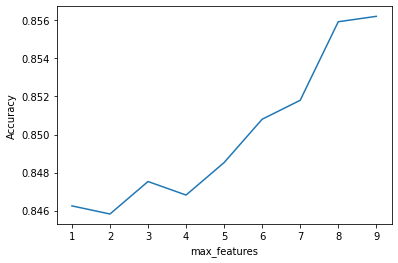

In [23]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

El comportamiento del desempeño del modelo en función de **max_features** presenta un comportamiento creciente, algo diferente a lo que normalmente ocurre: una función que presenta máximo y que no es monótonamente creciente. Este conjunto de datos muestra un comportamiento muy peculiar respecto a lo que se espera comúnmente. Por lo cual **siguiendo lo que nos muestra la gráfica y debido a que se desea tener cierta aleatoriedad en la selección de variables vamos a dejar 7 variables, casi la totalidad de ellas**.

##### Calibración del parámetro max_depth
Por último se calibra el parámetro **max_depth** que representa la profundidad  hasta la cual se realizarán particiones binarias en cada uno de los árboles del bosque aleatorio.

In [24]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    clf = RandomForestClassifier(n_estimators=60, max_features=7, max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

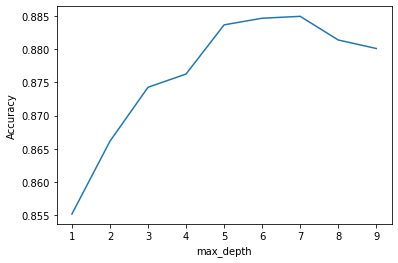

In [25]:
# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

El comportamiento del desempeño en función de **max_depth** es el único que presenta un valor máximo y luego decrece, que es lo que normalmente se espera, que la profundidad de cada árbol mejore el desempeño, pero que después de cierto punto ya no produzca aumentos significativos (la gráfica se estabilice) o que se deteriore levemente su desempeño (lo cual ocurre aquí). **Por lo tanto el valor óptimo en este caso es de 6 niveles de profundidad en los árboles del bosque aleatorio**.

**Algo importante de resaltar hasta aquí es que cada vez que se iba seleccionando el valor óptimo para un parámetro, y se iba usando en la siguiente calibración iba mejorando el accuracy o desempeño del modelo**. En la primera gráfica el máximo fue aproximadamente de 0.847, en la segunda de 0.852 y para la última calibración fue de 0.885. Lo cual muestra que cada valor seleccionado del parámetro fue modificando y mejorando el máximo desempeño del modelo.

##### Accuracy del modelo Random Forest en el conjunto de test (mejores valores en los parámetros)
Finalmente, vamos a evaluar el accuracy del modelo en el conjunto de train y test para analizar si ha mejorado el sobre-ajuste (overfitting) que presentaba el modelo Random Forest sin calibrar (el del punto 4 de este laboratorio).

In [47]:
# Definición del modelo con los parámetros max_features=7, max_depth=6 y n_estimators=60 
clf = RandomForestClassifier(n_estimators=60, max_features=7, max_depth=6, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

# Predicciones con el Random Forest y los mejores valores de los parámetros
y_pred_train = clf.predict(X_train) # Predicción en train
y_pred_test = clf.predict(X_test) # Predicción en test

# Calculo del accuracy para modelo Random Forest con los mejores valores de los parámetros
acc_train = accuracy_score(y_train, y_pred_train) # Accuracy en train
acc_test = accuracy_score(y_test, y_pred_test) # Accuracy en test

acc_rdf_cal_test = acc_test

print('Accuracy evaluado respecto a la muestra de train: ', acc_train)
print('Accuracy evaluado respecto a la muestra de test: ', acc_test)

Accuracy evaluado respecto a la muestra de train:  0.8946095861186175
Accuracy evaluado respecto a la muestra de test:  0.8830831408775982


**Como se puede ver ha mejorado el accuracy en la conjunto de test del modelo sin calibrar al modelo calibrado (paso de 0.843 a 0.888)**. Adicionalmente, **se hace notar que el sobre-ajuste (overfitting) ha sido corregido con la calibración ya que ahora los accuracy medidos en train y test dan similares, 0.894 en train y 0.883 en test**, es decir, se ha logrado aumentar el accuracy en test al calibrar el modelo y reducirlo en train de tal forma que ahora son similares, permitiendo confiar en el poder predictivo del modelo para datos nuevos, esto es, en la cualidad de generalización que debe tener.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [27]:
!pip install xgboost
from xgboost import XGBClassifier

     |████████████████████████████████| 193.7 MB 53 kB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [28]:
# Celda 6


# Importación y definición de modelo XGBClassifier
clf = XGBClassifier()

# Entrenamiento (fit) del modelo XGBClassifier
clf.fit(X_train, y_train)

# Predicciones con el XGBoost y los parámetros por defecto
y_pred_train = clf.predict(X_train) # Predicción en train
y_pred_test = clf.predict(X_test) # Predicción en test

# Calculo del accuracy para modelo XGBoost con parámetros por defecto
acc_xgb_def_lib_train = accuracy_score(y_train.values, y_pred_train) # Accuracy en train
acc_xgb_def_lib_test = accuracy_score(y_test.values, y_pred_test) # Accuracy en test
print('Accuracy evaluado respecto a la muestra de train: ', acc_xgb_def_lib_train)
print('Accuracy evaluado respecto a la muestra de test: ', acc_xgb_def_lib_test)


Accuracy evaluado respecto a la muestra de train:  0.9180770871853221
Accuracy evaluado respecto a la muestra de test:  0.870958429561201


En la celda anterior se ha implementado, entrenado y evaluado un modelo de XGBoost  con los parámetros por defecto. **El modelo XGBoost se ha evaluado calculando el accurray en el conjunto de train y el de test**, y al compararlos **se puede ver una ligera diferencia en el modelo porque en el conjunto de train hay un valor del accuracy de 0.918, y un valor ligeramente menor para el accuracy en el conjunto de test 0.871**. El valor del accuracy en test es similar al valor encontrado con el modelo calibrado de Random Forest, esto da buenos indicios de mejorar y superar el poder predictivo al realizar la calibración del modelo XGBoost. La diferencia entre los accuracy en test y train, y los valores en si puede mejorarse al calibrar algunos parámetros del modelo con el ánimo de tener un mayor poder predictivo y de generalización. Se evaluará en la siguiente sección si se pueden aumentar los valores del accuracy (en train y test) y hacer que sean mucho más cercanos entre ellos, consiguiendo así la generalización buscada para predecir en nuevos valores.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

##### Calibración del parámetro learning_rate
Se inicia calibrando el parámetro **learning_rate**, es decir, la rapidez con la que aprenderá el modelo de boosting.

In [37]:
from sklearn.model_selection import cross_val_score
# Celda 7
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
learning_range = range(0, 100, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de learning_range
for rate in learning_range:
    clf = XGBClassifier(learning_rate=rate/100, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

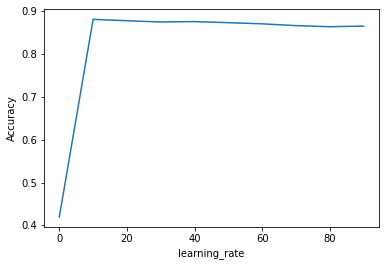

In [38]:
# Gráfica del desempeño del modelo vs el learning rate
plt.plot(learning_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')

A partir del gráfico se puede notar que la **función de desempeño del modelo toma un máximo  para learning_rate=0.10** y luego decrece levemente. 

El comportamiento con el parámetro learning_rate es el esperado, que aumente al aumentar la tasa de aprendizaje, pero si aprende demasiado rápido pierda de nuevo desempeño, una función del tipo convexa.

##### Calibración del parámetro gamma
Se continua calibrando el parámetro **gamma**, es decir, la disminución mínima requerida para realizar otra partición.

In [39]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
gamma_range = range(0, 10, 1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for gamm in gamma_range:
    clf = XGBClassifier(learning_rate=0.1, gamma=gamm/100, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

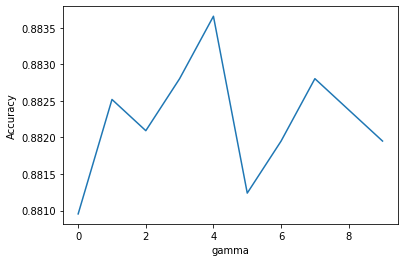

In [40]:
# Gráfica del desempeño del modelo vs el indice gamma
plt.plot(gamma_range, accuracy_scores)
plt.xlabel('gamma')
plt.ylabel('Accuracy')

El desempeño del modelo con respecto al parámetro **gamma toma el máximo en 0.04**.

Para esta gráfica hay un comportamiento de una función creciente en la primera parte de los valores de gamma y luego empieza a disminuir para valores mayores del parámetro. Aquí se usó un rango del parámetro gamma entre 0 y 0.1.

##### Calibración del parámetro colsample_bytree
Finalmente se calibra el parámetro **colsample_bytree**, es decir, el submuestreo a las columnas de los datos a utilizar en cada árbol construido.

In [41]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
col_range = range(0, 100, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for col in col_range:
    clf = XGBClassifier(learning_rate=0.1, gamma=0.04, colsample_bytree=col/100,random_state=1,  n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

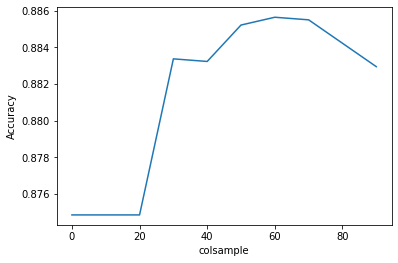

In [42]:
# Gráfica del desempeño del modelo vs el indice de submuestreo de columnas
plt.plot(col_range, accuracy_scores)
plt.xlabel('colsample')
plt.ylabel('Accuracy')

El desempeño del modelo respecto al **parámetro colsample_bytree presenta su valor máximo en 0.60.**

El comportamiento funcional de la gráfica es una curva convexa que permite distinguir un valor óptimo del parámetro de submuestreo de columnas de datos a utilizar en cada árbol contruido.

##### Accuracy del modelo XGBoost en el conjunto de test (mejores valores en los parámetros)
Finalmente, vamos a evaluar el accuracy del modelo en el conjunto de train y test para analizar si hemos mejorado el sobre-ajuste (overfitting) que presentaba nuestro modelo XGBoost sin calibrar (el del punto 6 de este laboratorio).

In [49]:
# Definición del modelo con los parámetros learning_rate=0.1, gamma=0.07 y colsample=0.5 
clf = XGBClassifier(learning_rate=0.1, gamma=0.04, colsample_bytree=0.6, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

# Predicciones con el Random Forest y los mejores valores de los parámetros
y_pred_train = clf.predict(X_train) # Predicción en train
y_pred_test = clf.predict(X_test) # Predicción en test

# Calculo del accuracy para modelo Random Forest con los mejores valores de los parámetros
acc_train = accuracy_score(y_train, y_pred_train) # Accuracy en train
acc_test = accuracy_score(y_test, y_pred_test) # Accuracy en test

acc_xgb_cal_test = acc_test

print('Accuracy evaluado respecto a la muestra de train: ', acc_train)
print('Accuracy evaluado respecto a la muestra de test: ', acc_test)

Accuracy evaluado respecto a la muestra de train:  0.9011520409614564
Accuracy evaluado respecto a la muestra de test:  0.8807736720554272


**Como se puede ver ha mejorado el accuracy en la conjunto de test del modelo sin calibrar al modelo calibrado de XGBoost (paso de 0.871 a 0.881)**. También **se puede notar que la diferencia para el modelo calibrado entre el accuraccy de la muestra de train y la de test se redujo un poco, 0.901 en train y 0.881 en test**, es decir, al ser más cercanos se puede considerar que el poder de generalización del modelo mejoró un poco respecto al modelo XGBoost sin calibrar.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

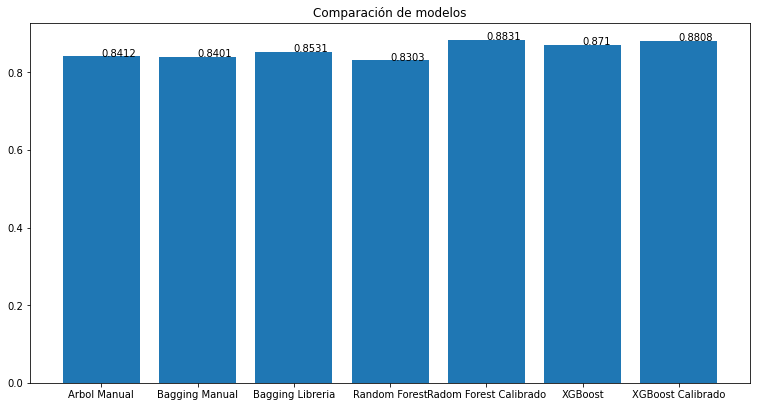

In [50]:
# Celda 8
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['Arbol Manual', 'Bagging Manual','Bagging Libreria', 'Random Forest', 'Radom Forest Calibrado', 'XGBoost', 'XGBoost Calibrado']
ejeY = np.around([man_tre_acc,clas_tree_acc,bag_tree_acc,acc_rf_default_test,acc_rdf_cal_test,acc_xgb_def_lib_test,acc_xgb_cal_test],4)
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

En la gráfica se observa la **comparativa del desempeño (accuracy) de los 7 modelos desarrolados** en el laboratorio:
- 'Arbol Manual',
- 'Bagging Manual',
- 'Bagging Libreria', 
- 'Random Forest', 
- 'Radom Forest Calibrado', 
- 'XGBoost', 
- 'XGBoost Calibrado'

Los modelos con **desempeño de resaltar son el random forest calibrado y el xgboost calibrado**, se esparaba un desempeño mayor del XGBoost calibrado respecto al random forest pues en su versión original presentaba un mejor desempeño. **En este escenario se consideraria recomendar el uso del random forest calibrado pues tiene una menor exigencia computacional y presenta buenos resultados.**

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=456e49a2-fe28-4a38-82bc-bdb5398a2120' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>